All of the necessary imports for this script

In [2]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

All of the variable necessary for interacting with the Alpha Vantage Stock API

In [3]:
API_KEY = "Your AlphaVantage API Key"
ti = TechIndicators(API_KEY, 'pandas')
ts = TimeSeries(API_KEY, 'pandas')

Variables necessary for the Average Change Rank indicator

Ticker: Ticker Symbol for the stock you would like to apply this indicator to (only works for NYSE stocks)
Period: The amount of candlesticks we will average 
High: If the indicator is above this value, this is an indication to open up a short position
Low: If the indicator is below this value, this is an indication to open a long position
Mid: If the indicator is at this value, this is an indication to close all positions

In [4]:
Ticker = "SPY"
Period = 24
High = 90
Low = 10
Mid = 50

Retreiving the daily price data for the given Ticker Symbol.
Returns Open Price, Close Price, and Intra-day price change as a percentage

In [5]:
prices, meta_prices = ts.get_daily(Ticker, "full")

prices = prices.rename(columns={"4. close": "Close", 
                     "1. open": "Open"})

prices = prices.drop(["2. high", 
                      "3. low", 
                      "5. volume"], 
                        axis = 1)

prices["Change"] = prices.apply(lambda x: 100 * (x["Close"] - x["Open"]) / x["Open"] , axis = 1)

Calculates each day's Average change based on the specified period.
For example, if the period was 24, today's Average Change would be the average of today and the last 23 intraday percent changes.
This is calculated for every day where possible.

In [6]:
averageChanges = []

for x in range(len(prices["Change"]) + 1 - Period):
    
    CurrentChange = 0
    
    for y in range(x, x + Period):
        CurrentChange += prices["Change"][y] / Period
    
    averageChanges.append(CurrentChange)

Takes each average change calculated and converts it into a percentile.
This is what obtains the daily Average Change Rank.

In [7]:
sortedAvgChange = averageChanges.copy()
sortedAvgChange.sort()
AverageChangeRank = []

for x in averageChanges:
    
    for y in range(len(sortedAvgChange)):
        
        if sortedAvgChange[y] == x:
            AverageChangeRank.append(y * 100 / len(sortedAvgChange))

Adding the Average Change Rank to the existing prices dataframe.
We have to add null values to the array because you can't calculate an n-period average for the first n-1 entries of stock data.

In [8]:
addToDf = AverageChangeRank.copy()

for x in range(Period - 1):
    addToDf.append(None)
    
prices["Average Change Rank"] = addToDf
prices = prices.dropna()

Plotting the closing prices of the specified ticker and the Average Change Rank.
Only plotting the 300 most recent days since the plot becomes too cluttered if we include all of the data.

In order to properly graph closing price and Average Change Rank, we have to reverse the PlotClose and PlotAverageChangeRank arrays.
This way the earliest day is graphed first.

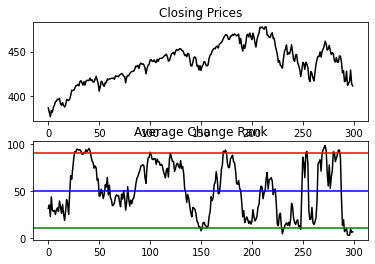

In [12]:
figure, axis = plt.subplots(2)

PlotClose = []
PlotAverageChangeRank = []
DaysToPlot = 300

for x in range(DaysToPlot):
    PlotClose.append(prices["Close"][x])
    PlotAverageChangeRank.append(prices["Average Change Rank"][x])

PlotClose = PlotClose[::-1]
PlotAverageChangeRank = PlotAverageChangeRank[::-1]

axis[0].plot(PlotClose, color = "black")    
axis[0].set_title("Closing Prices") 

axis[1].plot(PlotAverageChangeRank, color = "black")    
axis[1].set_title("Average Change Rank")
axis[1].axhline(y = High, color = "red")
axis[1].axhline(y = Low, color = "green")
axis[1].axhline(y = Mid, color = "blue")

plt.show()

Simulating trades over the course of the days that were plotted on the graph.

Buy Long Signal: When the Average Change Rank breaks above the Low threshold
|| Sell Long Signal: When the Average Change Rank breaks above the Mid-line

Buy Short Signal: When the Average Change Rank breaks below the High threshold
|| Sell Short Signal: When the Average Change Rank breaks below the Mid-line

These simulated trades assume that you are investing your entire portfolio in each trade, hence Profolio = 1 (100 %)

In [ ]:
Portfolio = 1
Position = False

CurrentPosPrice = 0


for x in range(1, len(PlotClose)):
    
    if((PlotAverageChangeRank[x] > Low) and (PlotAverageChangeRank[x-1] < Low) and (Position == False)):
        
        print("Buy Long at", PlotClose[x])
        CurrentPosPrice = PlotClose[x] 
        Position = True
    
    if ((PlotAverageChangeRank[x] > Mid) and (PlotAverageChangeRank[x-1] < Mid) and (Position == True)):
        
        print("Sell Long at", PlotClose[x])
        
        Profit = 100 * (PlotClose[x] - CurrentPosPrice) / CurrentPosPrice
        print("Profit:", Profit, "%")
        Portfolio *= (1 + (Profit / 100))
        
        print("")
        Position = False
    
    if((PlotAverageChangeRank[x] < High) and (PlotAverageChangeRank[x-1] > High) and (Position == False)):
        
        print("Buy Short at", PlotClose[x])
        CurrentPosPrice = PlotClose[x] 
        Position = True
    
    if ((PlotAverageChangeRank[x] < Mid) and (PlotAverageChangeRank[x-1] > Mid) and (Position == True)):
        
        print("Sell Short at", PlotClose[x])
        
        Profit = 100 * (CurrentPosPrice - PlotClose[x]) / CurrentPosPrice
        print("Profit:", Profit, "%")
        Portfolio *= (1 + (Profit / 100))
        
        print("")
        Position = False


Buy Short at 415.21
Sell Short at 405.41
Profit: 2.360251439030841 %

Buy Short at 441.02
Sell Short at 446.58
Profit: -1.2607137998276727 %

Buy Long at 434.9
Sell Long at 453.59
Profit: 4.297539664290642 %

Buy Short at 467.38
Sell Short at 455.56
Profit: 2.5289913988617383 %

Buy Long at 449.91
Sell Long at 437.75
Profit: -2.702762774777183 %

Buy Short at 432.17
Sell Short at 419.43
Profit: 2.947914015318048 %

Buy Short at 451.64
Sell Short at 438.06
Profit: 3.006819590824547 %



Comparing the returns of using just the Average Change Rank indicator and just holding.

In [ ]:
PercentageAverageChangeRank = 100* (Portfolio - 1)

if PercentageAverageChangeRank >= 0:
    print(PercentageAverageChangeRank,"%", "Profit with Average Change Rank")
    
if PercentageAverageChangeRank < 0:
    print(PercentageAverageChangeRank,"%", "Loss with Average Change Rank")
       
PercentageHolding = 100 * ((PlotClose[DaysToPlot - 1] - PlotClose[0]) / PlotClose[0])

if PercentageHolding >= 0:
    print(PercentageHolding,"%", "Profit with Holding")
    
if PercentageHolding < 0:
    print(PercentageHolding,"%", "Loss with Holding")

11.513157776716865 % Profit with Average Change Rank
6.41589486210999 % Profit with Holding
